# VASP TiO2 benchmark performance

This notebook compares the performance of the VASP TiO2 benchmark (pure DFT) between ARCHER and different configurations on ARCHER2.

Basic information:
- Uses `vasp_gam`
- `NELM = 10`

Performance summary:
- Best performance from VASP 6.3.0
- Best performance from 64 MPI processes per node - leaves 64 cores idle on each node
- Best performance with `NCORE = 64`
- Scales well to 16 nodes
- Using OpenMP threads results in worse performance

We compute performance using the maximum time for a "LOOP" cycle as reported by VASP.

Performance is plotted as LOOP per second (i.e. inverse of LOOP cycle time in seconds).

We have investigated the performance of different versions of VASP and different numerical libraries:

- On ARCHER: Intel Compilers 17, Cray FFTW, Intel MKL 17, Cray MPICH
- On ARCHER2: GCC compilers (v 10.x or 11.x), HPE Cray FFTW 3.3.8.x, HPE Cray MPICH, AOCL or HPE Cray LibSci

## Setup section

Import the required modules and define useful functions.

In [12]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [13]:
import sys
sys.path.append('../../../python-modules')

In [14]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [15]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

## Process data

In [16]:
results = [
    'ARCHER','ARCHER2-4c_LibSci-20.10',
    'ARCHER2-4c_LibSci-21.03',
    'ARCHER2-4c_AOCL-3.0', 
    'ARCHER2_VASP544_LibSci-21.04_OFI',
    'ARCHER2_VASP630_AOCL-3.1_OFI',
    'ARCHER2_VASP544_LibSci-21.04_UCX',
    'ARCHER2_VASP630_AOCL-3.1_UCX',
    'ARCHER2_VASP631_AOCL-3.1_UCX'
          ]
systems = {
    'ARCHER': 'ARCHER',
    'ARCHER2-4c_LibSci-20.10': 'ARCHER2',
    'ARCHER2-4c_LibSci-21.03': 'ARCHER2',
    'ARCHER2-4c_MKL-19.5': 'ARCHER2',
    'ARCHER2-4c_MKL-21.2': 'ARCHER2',
    'ARCHER2-4c_AOCL-3.0': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04_OFI': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1_OFI': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04_UCX': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1_UCX': 'ARCHER2',
    'ARCHER2_VASP631_AOCL-3.1_UCX': 'ARCHER2'
}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../TiO2/results/' + res
    filelist = filemanip.get_filelist(wdir, 'TiO2MCC_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
2     48        1       48    6     8    1     0.000716  0.000716  0.000716   
                              12    4    1     0.000738  0.000738  0.000738   
4     96        1       96    12    8    1     0.001454  0.001454  0.001454   
                              24    4    1     0.001441  0.001441  0.001441   
8     192       1       192   48    4    1     0.002767  0.002767  0.002767   
16    384       1       384   96    4    1     0.004865  0.004865  0.004865   
32    768       1       768   192   4    1     0.011049  0.011049  0.011049   

                                                              LOOP             \
                                                   mean        min     median   
Nodes Processes Threads Cores NCORE NPA

## Performance Comparison

This plot compares performance for different systems/configurations with respect to "reserved" cores. Reserved cores is defined as the number of nodes multiplied by the total number of cores per node and represents the amount of resource reserved for the run rather than the number of cores used. This is used to be able to compare performance across different systems even when not all cores on a compute node are used.

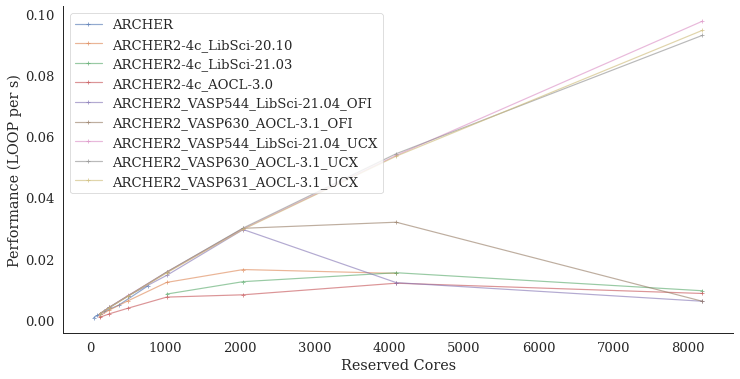

In [17]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (LOOP per s)')
plt.legend(loc='best')
sns.despine()
# plt.savefig('vasp_tio2_perf.png', dpi=300)

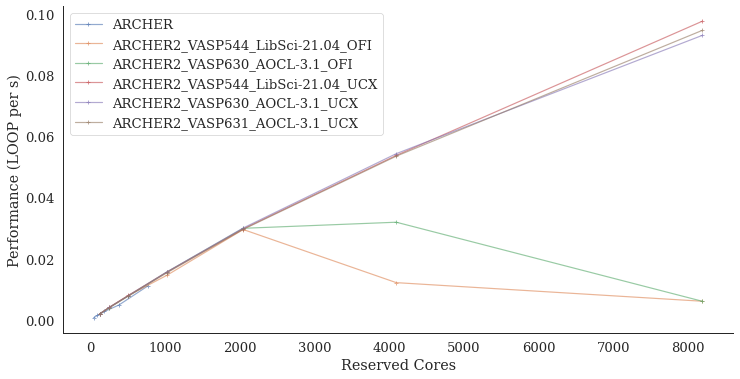

In [18]:
results = [
    'ARCHER',
    'ARCHER2_VASP544_LibSci-21.04_OFI',
    'ARCHER2_VASP630_AOCL-3.1_OFI',
    'ARCHER2_VASP544_LibSci-21.04_UCX',
    'ARCHER2_VASP630_AOCL-3.1_UCX',
    'ARCHER2_VASP631_AOCL-3.1_UCX'
          ]
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (LOOP per s)')
plt.legend(loc='best')
sns.despine()
# plt.savefig('vasp_tio2_perf.png', dpi=300)

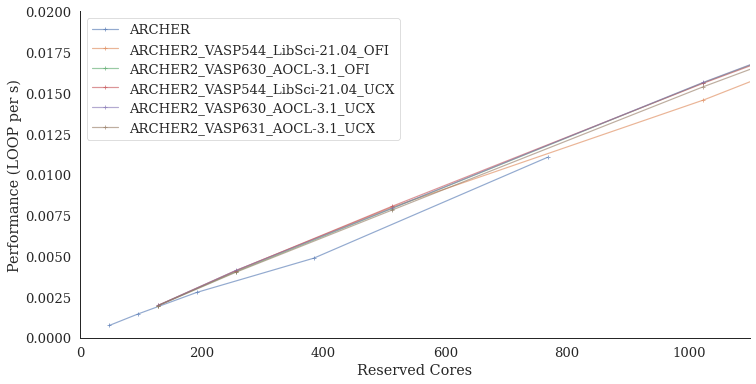

In [19]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.xlim([0,1100])
plt.ylim([0,0.02])
plt.ylabel('Performance (LOOP per s)')
plt.legend(loc='best')
sns.despine()
# plt.savefig('vasp_tio2_perf_zoom.png', dpi=300)